In [1]:
prom_file_path = "prom_pure_label.parquet"

In [2]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras import regularizers

2023-08-08 09:05:29.747319: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 09:05:29.817556: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 09:05:30.279103: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 09:05:30.283489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 09:05:31.644845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
import pandas as pd
prom_df = pd.read_parquet(prom_file_path)

In [ ]:
prom_df

,timestamp,node,node_load15,node_load5,node_load1,node_memory_Active_bytes,node_filesystem_device_error-sum,node_netstat_Icmp_InErrors,node_netstat_Tcp_InErrs,node_netstat_Udp_InErrors,nvidia_gpu_power_usage_milliwatts-max,nvidia_gpu_temperature_celsius-max,isAnomaly
0,2022-08-01 23:00:30,r12n20,3.25,2.43,4.40,4.585050e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
1,2022-08-01 23:01:00,r12n20,3.21,2.41,3.49,4.195340e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
2,2022-08-01 23:01:30,r12n20,3.14,2.27,2.51,4.248640e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
3,2022-08-01 23:02:00,r12n20,3.07,2.15,1.91,4.248610e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
4,2022-08-01 23:02:30,r12n20,3.01,2.05,1.63,4.266120e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123565292,2022-09-30 11:20:00,r35n5,6.33,2.92,1.16,1.612260e+10,0.0,97.0,0.0,0.0,156186.0,57.0,0
123565293,2022-09-30 11:20:30,r35n5,6.16,2.73,1.10,1.610200e+10,0.0,97.0,0.0,0.0,160405.0,55.0,0
123565294,2022-09-30 11:21:00,r35n5,5.99,2.55,0.99,1.612250e+10,0.0,97.0,0.0,0.0,165284.0,58.0,0
123565295,2022-09-30 11:21:30,r35n5,5.83,2.40,1.00,1.612330e+10,0.0,97.0,0.0,0.0,164491.0,60.0,0


In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint
feature_cols = [col for col in prom_df.columns if col not in ['node', 'timestamp', 'isAnomaly','node_netstat_Udp_InErrors','node_netstat_Tcp_InErrs','node_netstat_Icmp_InErrors','node_filesystem_device_error-sum']]
X = prom_df[feature_cols]
y = prom_df['isAnomaly']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X.shape[1]  
encoding_dim = 14  
batch_size = 32
epochs = 10

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer=Adam(), 
                    loss='mean_squared_error', 
                    metrics=['mae'])

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',  
                             monitor='val_loss',  
                             verbose=0,  
                             save_best_only=True,  
                             mode='auto')  

history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_scaled, X_scaled),
                          callbacks=[checkpoint])  

Epoch 1/10
3861416/3861416 [==============================] - 17345s 4ms/step - loss: 0.0744 - mae: 0.1917 - val_loss: 0.0610 - val_mae: 0.1831
Epoch 2/10
3861416/3861416 [==============================] - 17817s 5ms/step - loss: 0.0650 - mae: 0.1898 - val_loss: 0.0603 - val_mae: 0.1827
Epoch 3/10
3861416/3861416 [==============================] - 13793s 4ms/step - loss: 0.0636 - mae: 0.1891 - val_loss: 0.0610 - val_mae: 0.1839
Epoch 4/10
3861416/3861416 [==============================] - 15851s 4ms/step - loss: 0.0624 - mae: 0.1885 - val_loss: 0.0657 - val_mae: 0.1994
Epoch 5/10
3861416/3861416 [==============================] - 15885s 4ms/step - loss: 0.0627 - mae: 0.1888 - val_loss: 0.0613 - val_mae: 0.1836
Epoch 6/10
3164634/3861416 [=======================>......] - ETA: 31:18 - loss: 0.0636 - mae: 0.1903

In [4]:
from tensorflow.keras.models import load_model
feature_cols = [col for col in prom_df.columns if col not in ['node', 'timestamp', 'isAnomaly','node_netstat_Udp_InErrors','node_netstat_Tcp_InErrs','node_netstat_Icmp_InErrors','node_filesystem_device_error-sum']]
X = prom_df[feature_cols]
y = prom_df['isAnomaly']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X.shape[1]  
encoding_dim = 14  
batch_size = 32
epochs = 10
autoencoder = load_model('model-002.h5')

predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)

threshold = np.quantile(mse, 0.972)  

y_pred = [1 if e > threshold else 0 for e in mse]


3861416/3861416 [==============================] - 3667s 949us/step


              precision    recall  f1-score   support

           0       0.98      0.98      0.98 120006718
           1       0.17      0.17      0.17   3558579

    accuracy                           0.95 123565297
   macro avg       0.57      0.57      0.57 123565297
weighted avg       0.95      0.95      0.95 123565297

Confusion matrix:
 [[117141114   2865604]
 [  2964354    594225]]
ROC AUC Score: 0.5715525455527657


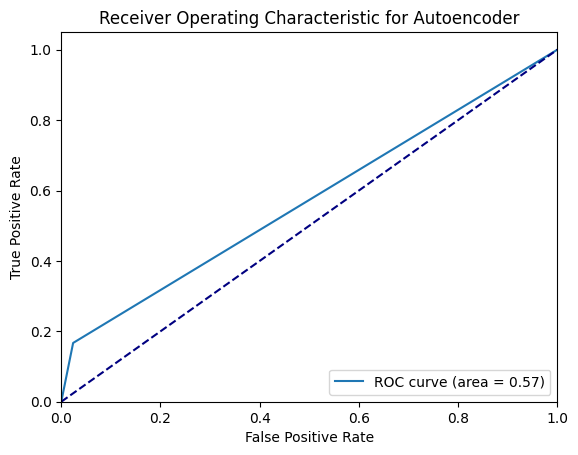

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np


print(classification_report(y, y_pred))

conf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix:\n', conf_mat)

roc_auc = roc_auc_score(y, y_pred)
print('ROC AUC Score:', roc_auc)

fpr, tpr, _ = roc_curve(y, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Autoencoder')
plt.legend(loc="lower right")

plt.savefig('autoencoder_roc_curve.pdf', format='pdf')

plt.show()


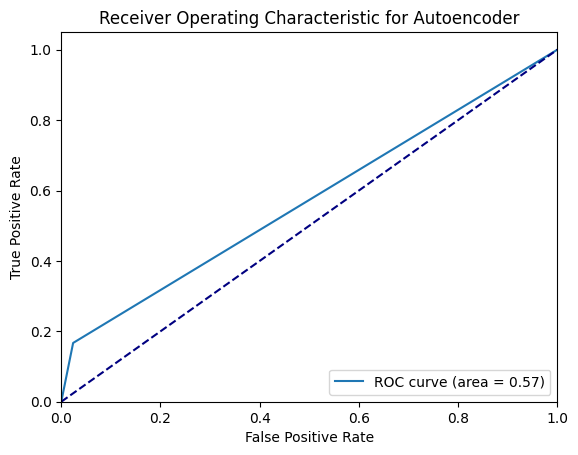

In [6]:
fpr, tpr, _ = roc_curve(y, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Autoencoder')
plt.legend(loc="lower right")

plt.savefig('autoencoder_roc_curve.pdf', format='pdf')

plt.show()

In [ ]:
from tensorflow.keras.models import load_model
feature_cols = [col for col in prom_df.columns if col not in ['node', 'timestamp', 'isAnomaly','node_netstat_Udp_InErrors','node_netstat_Tcp_InErrs','node_netstat_Icmp_InErrors','node_filesystem_device_error-sum']]
X = prom_df[feature_cols]
y = prom_df['isAnomaly']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X.shape[1]  
encoding_dim = 14  
batch_size = 32
epochs = 10
autoencoder = load_model('model-002.h5')

predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)

threshold = np.quantile(mse, 0.972)  

y_pred = [1 if e > threshold else 0 for e in mse]

print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

In [ ]:
predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)

threshold = np.quantile(mse, 0.972)  

y_pred = [1 if e > threshold else 0 for e in mse]

print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

12758/12758 [==============================] - 12s 903us/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    405236
           1       0.01      0.02      0.01      3018

    accuracy                           0.96    408254
   macro avg       0.50      0.50      0.50    408254
weighted avg       0.99      0.96      0.97    408254

[[393875  11361]
 [  2947     71]]
